In [12]:
!pip install prophet
!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import random
from datetime import datetime, timedelta
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, FloatType, IntegerType, StringType, TimestampType, BooleanType
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Initialize Spark session
spark = SparkSession.builder.appName("FraudClassificationSchema").getOrCreate()



# Example of how to add data to the DataFrame (you would replace this with your actual data loading logic)
# sample_data = [
#     (100.0, "2023-09-06 10:30:00", "purchase", 5411, 365, 1000.0, 750, 2, 80.0, 2.5, 3, False, "US", 0.0, 0.1, 1, 5, 100.0, False, 10, "mobile", "en-US", False, False, 1),
#     # Add more rows as needed
# ]
# df = spark.createDataFrame(sample_data, schema=fraud_schema)

# Show the first few rows of the DataFrame (if you've added data)
# df.show(5)

In [ ]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, FloatType, IntegerType, StringType, TimestampType, BooleanType
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Initialize Spark session
spark = SparkSession.builder.appName("FraudClassificationSchema").getOrCreate()



# Example of how to add data to the DataFrame (you would replace this with your actual data loading logic)
# sample_data = [
#     (100.0, "2023-09-06 10:30:00", "purchase", 5411, 365, 1000.0, 750, 2, 80.0, 2.5, 3, False, "US", 0.0, 0.1, 1, 5, 100.0, False, 10, "mobile", "en-US", False, False, 1),
#     # Add more rows as needed
# ]
# df = spark.createDataFrame(sample_data, schema=fraud_schema)

# Show the first few rows of the DataFrame (if you've added data)
# df.show(5)

In [2]:
def time_to_value(t, base_value, amplitude, noise_level, scale=1):
    if scale is None:
        return None
    hours = t.hour + t.minute / 60 + t.second / 3600
    x = hours / 24 * 2 * np.pi
    y = (np.sin(x) + np.sin(2*x)) / 2
    value = base_value + amplitude * y + np.random.normal(0, noise_level)
    return float(max(0, value * scale))

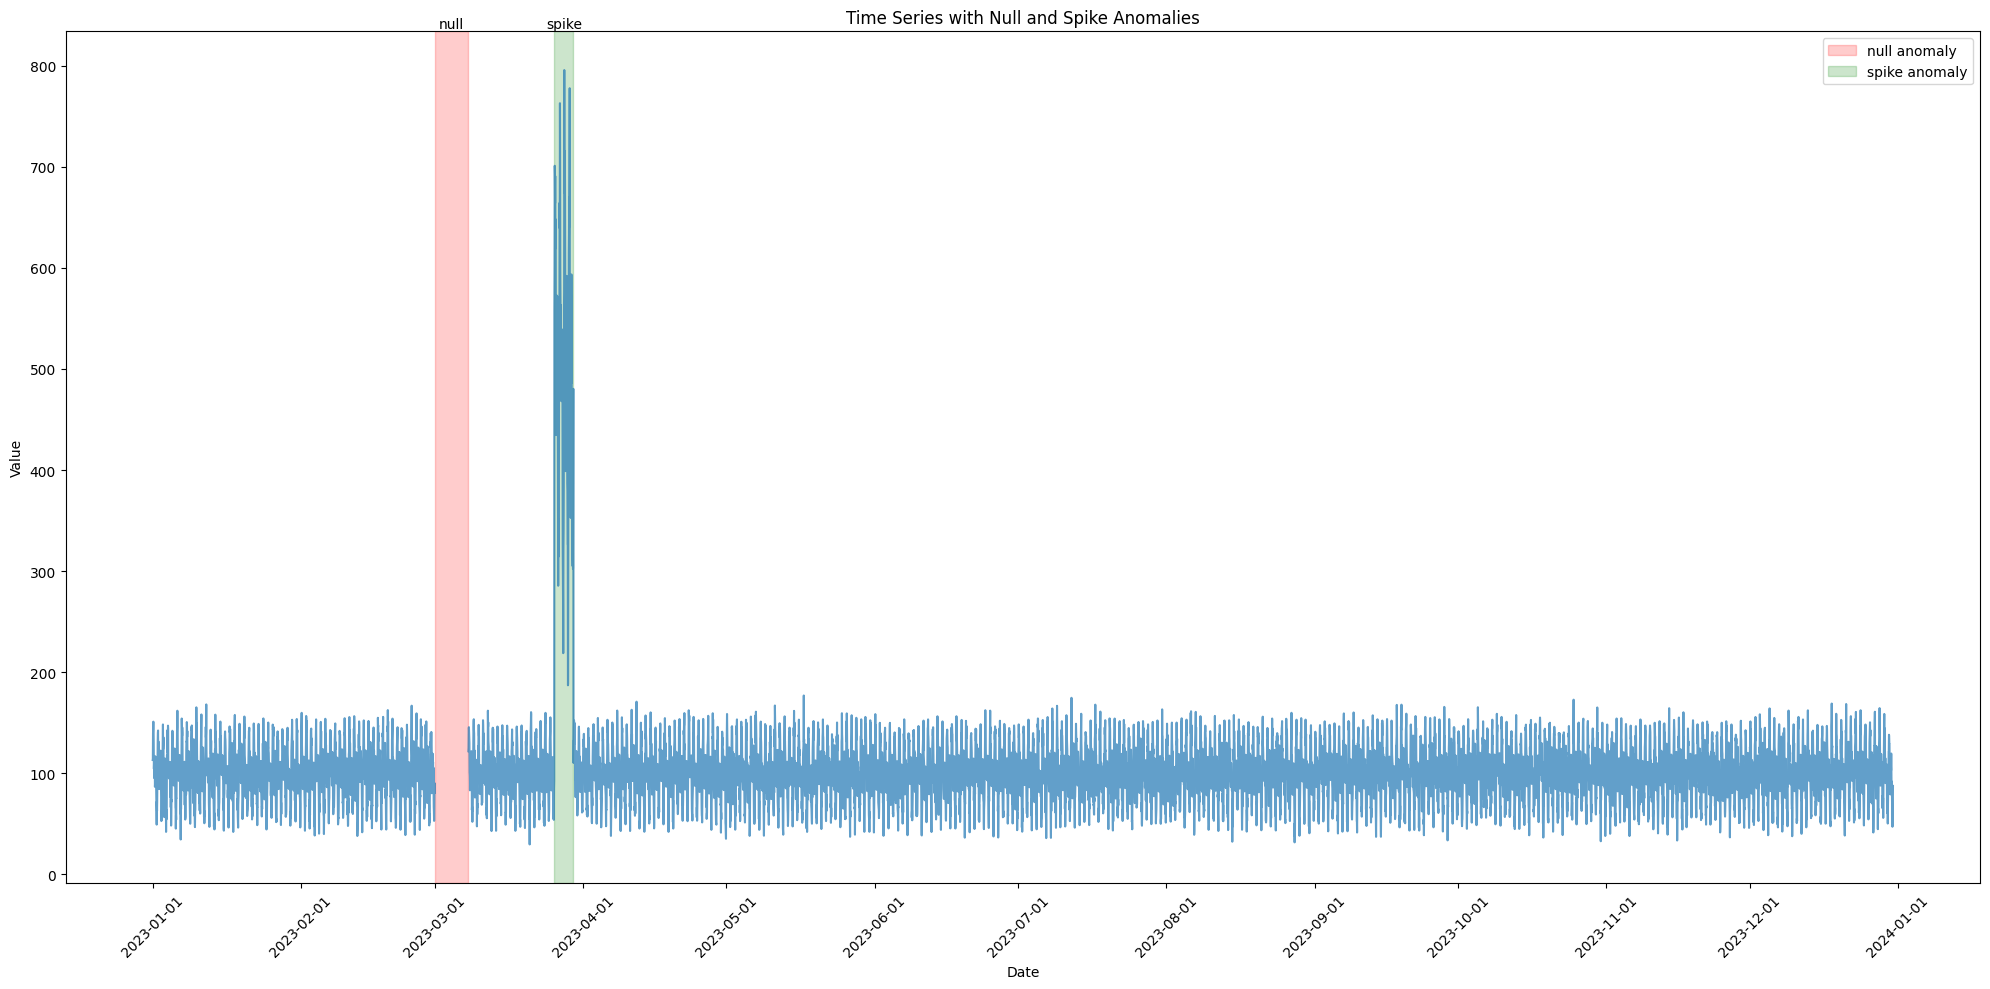

In [3]:


def generate_non_overlapping_windows(start_date, end_date, num_windows):
    total_days = (end_date - start_date).days
    window_lengths = [random.randint(3, 7) for _ in range(num_windows)]
    gap_days = random.randint(7, 30)
    gap = timedelta(days=gap_days)
    windows = []
    current_start = start_date + timedelta(days=random.randint(0, total_days - sum(window_lengths) - gap_days))
    for length in window_lengths:
        window_end = current_start + timedelta(days=length)
        if window_end > end_date:
            break
        windows.append((current_start, window_end))
        current_start = window_end + gap
        if current_start >= end_date:
            break
    
    return windows

def generate_timeseries_with_anomalies(num_samples=1000, base_value=100, amplitude=50, noise_level=10):
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)
    
    anomaly_windows = generate_non_overlapping_windows(start_date, end_date, 2)
    null_window, spike_window = anomaly_windows
    
    data = []
    time_delta = (end_date - start_date) / num_samples

    for i in range(num_samples):
        transaction_time = start_date + i * time_delta

        
        # Determine if we're in an anomaly window
        if null_window[0] <= transaction_time <= null_window[1]:
            scale = None
        elif spike_window[0] <= transaction_time <= spike_window[1]:
            scale = 5  # Spike multiplier
        else:
            scale = 1
        

        value = time_to_value(transaction_time, base_value=base_value, amplitude=amplitude, noise_level=noise_level, scale=scale)
        
        data.append((transaction_time, value))

    return data, {'null': null_window, 'spike': spike_window}

# Generate the time series data
timeseries_data, anomaly_windows = generate_timeseries_with_anomalies(num_samples=10000)

# Convert to numpy arrays for easier plotting
times, values = zip(*timeseries_data)
times = np.array(times)
values = np.array(values)

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(times, values, alpha=0.7)
plt.title('Time Series with Null and Spike Anomalies')
plt.xlabel('Date')
plt.ylabel('Value')

# Highlight anomaly windows
colors = {'null': 'red', 'spike': 'green'}
for anomaly_type, (start, end) in anomaly_windows.items():
    plt.axvspan(start, end, alpha=0.2, color=colors[anomaly_type], label=f'{anomaly_type} anomaly')
    
    # Annotate the anomaly period
    mid_point = start + (end - start) / 2
    plt.annotate(anomaly_type, (mid_point, plt.gca().get_ylim()[1]), 
                 ha='center', va='bottom', rotation=0)

plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Define the schema
fraud_fields = [
    StructField("transaction_amount", DoubleType(), True),
    StructField("transaction_time", TimestampType(), True),
    StructField("transaction_type", StringType(), True),
    StructField("merchant_category_code", IntegerType(), True),
    StructField("account_age", IntegerType(), True),
    StructField("account_balance", DoubleType(), True),
    StructField("credit_score", IntegerType(), True),
    StructField("number_of_cards", IntegerType(), True),
    StructField("average_transaction_amount", DoubleType(), True),
    StructField("transaction_frequency", DoubleType(), True),
    StructField("number_of_devices", IntegerType(), True),
    StructField("unusual_hour_flag", BooleanType(), True),
    StructField("transaction_country", StringType(), True),
    StructField("distance_from_last_transaction", DoubleType(), True),
    StructField("ip_address_risk_score", DoubleType(), True),
    StructField("transactions_last_hour", IntegerType(), True),
    StructField("transactions_last_day", IntegerType(), True),
    StructField("amount_last_hour", DoubleType(), True),
    StructField("new_beneficiary_flag", BooleanType(), True),
    StructField("common_beneficiary_count", IntegerType(), True),
    StructField("device_type", StringType(), True),
    StructField("browser_language", StringType(), True),
    StructField("proxy_flag", BooleanType(), True),
    StructField("previous_fraud_flag", BooleanType(), True),
    StructField("days_since_last_transaction", IntegerType(), True)
]

fraud_schema = StructType(fraud_fields)

def generate_sample_data(num_samples=10000):
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)
      
    data = []
    time_delta = (end_date - start_date) / num_samples
    # Generate base values
    transaction_amount, _ = generate_timeseries_with_anomalies(num_samples=num_samples, base_value=100, amplitude=50, noise_level=10)
    account_balance, _ = generate_timeseries_with_anomalies(num_samples=num_samples, base_value=5000, amplitude=2000, noise_level=500)
    average_transaction_amount, _ = generate_timeseries_with_anomalies(num_samples=num_samples, base_value=80, amplitude=30, noise_level=5)
    transaction_frequency, _ = generate_timeseries_with_anomalies(num_samples=num_samples, base_value=5, amplitude=3, noise_level=1)

    # print(len(transaction_amount), len(transaction_frequency), len(average_transaction_amount), len(account_balance))
    for i in range(num_samples):
        transaction_time = start_date + i * time_delta
        
        # Generate other features
        row = [
            transaction_amount[i][1],
            transaction_time,
            random.choice(['purchase', 'withdrawal', 'transfer']),
            random.randint(1000, 9999),
            random.randint(1, 3650),
            account_balance[i][1],
            random.randint(300, 850),
            random.randint(1, 5),
            average_transaction_amount[i][1],
            transaction_frequency[i][1],
            random.randint(1, 5),
            random.choice([True, False]),
            random.choice(['US', 'UK', 'CA', 'AU', 'DE', 'FR']),
            float(max(0, random.gauss(50, 30))),
            float(random.uniform(0, 1)),
            random.randint(0, 10),
            random.randint(0, 50),
            float(max(0, random.gauss(1000, 500))),
            random.choice([True, False]),
            random.randint(0, 100),
            random.choice(['mobile', 'desktop', 'tablet']),
            random.choice(['en-US', 'es-ES', 'fr-FR', 'de-DE', 'zh-CN']),
            random.choice([True, False]),
            random.choice([True, False]),
            random.randint(0, 365)
        ]
        
        data.append(tuple(row))
    return data
    

In [5]:
data = generate_sample_data(20000)

In [6]:
df = spark.createDataFrame(data, schema=fraud_schema)

In [7]:
df.show()

+------------------+--------------------+----------------+----------------------+-----------+------------------+------------+---------------+--------------------------+---------------------+-----------------+-----------------+-------------------+------------------------------+---------------------+----------------------+---------------------+------------------+--------------------+------------------------+-----------+----------------+----------+-------------------+---------------------------+
|transaction_amount|    transaction_time|transaction_type|merchant_category_code|account_age|   account_balance|credit_score|number_of_cards|average_transaction_amount|transaction_frequency|number_of_devices|unusual_hour_flag|transaction_country|distance_from_last_transaction|ip_address_risk_score|transactions_last_hour|transactions_last_day|  amount_last_hour|new_beneficiary_flag|common_beneficiary_count|device_type|browser_language|proxy_flag|previous_fraud_flag|days_since_last_transaction|
+---

/home/nikhil/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


/home/nikhil/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/nikhil/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


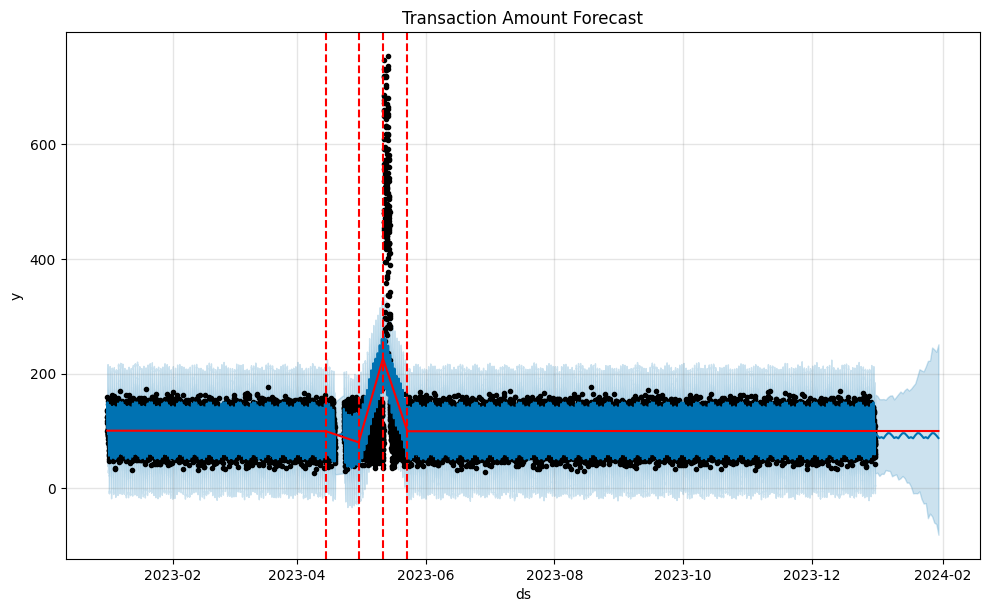

/home/nikhil/.local/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/nikhil/.local/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/nikhil/.local/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

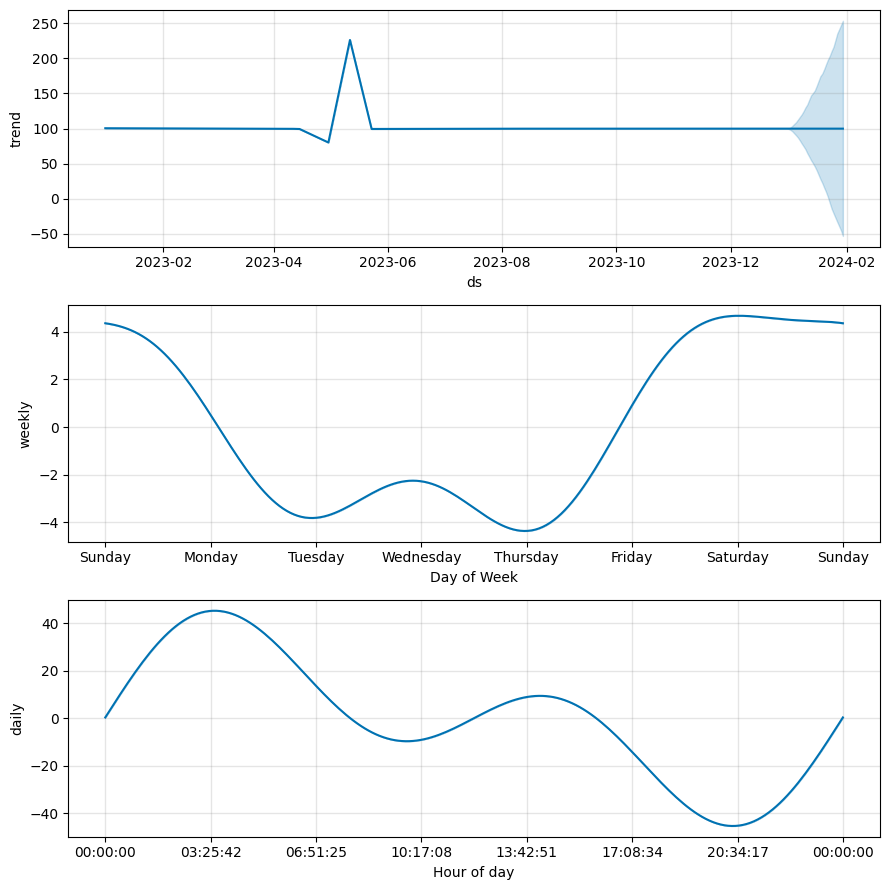

Number of anomalies detected: 668


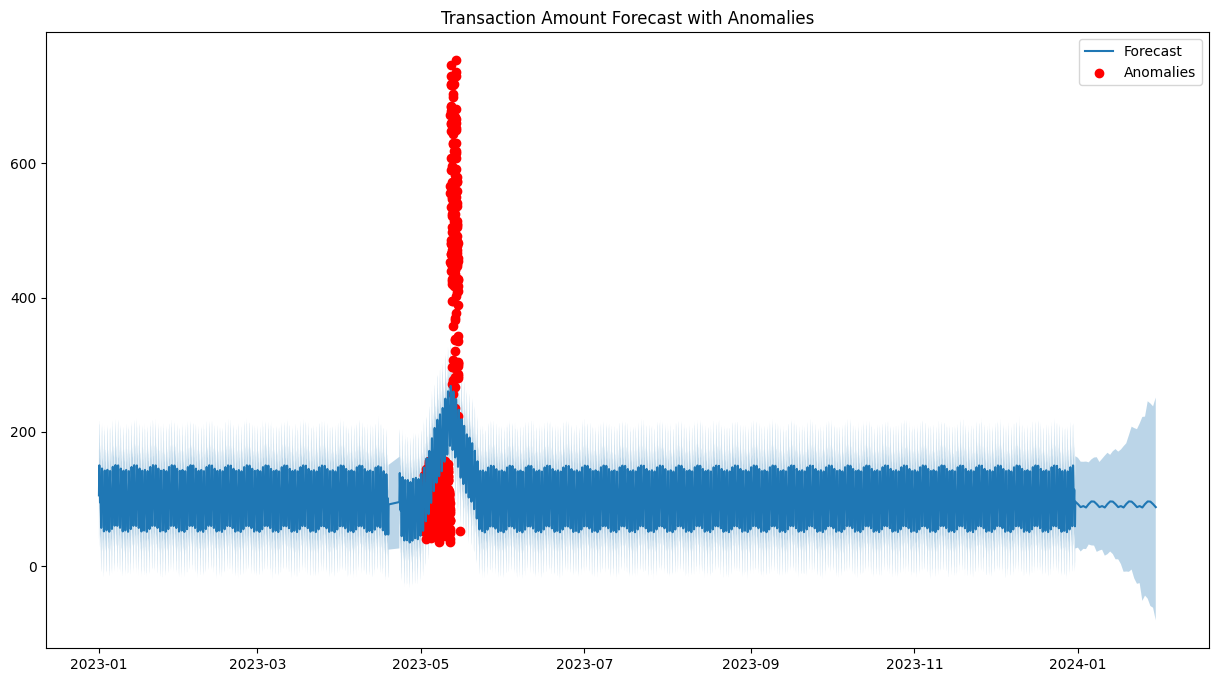

                          ds           y        yhat  yhat_lower  yhat_upper
6633 2023-05-01 17:17:39.840   64.814929  143.155768   69.939459  209.332480
6634 2023-05-01 17:43:52.320   72.069489  137.474262   73.539644  200.927222
6638 2023-05-01 19:28:42.240   51.500560  116.917106   54.957262  186.261120
6659 2023-05-02 04:39:04.320  135.192695  203.994713  142.285009  269.447796
6661 2023-05-02 05:31:29.280  124.168954  197.007404  129.552592  263.156400
...                      ...         ...         ...         ...         ...
7359 2023-05-14 22:24:40.320  300.583583  112.944338   44.014641  180.087306
7360 2023-05-14 22:50:52.800  410.405187  119.257800   57.184756  186.073087
7361 2023-05-14 23:17:05.280  481.649965  126.646701   58.518626  197.348550
7362 2023-05-14 23:43:17.760  458.980857  134.819371   70.461410  203.453713
7404 2023-05-15 18:04:01.920   52.648255  120.022276   58.963133  187.251427

[668 rows x 5 columns]


In [8]:
# use prophet

# Import necessary libraries
from pyspark.sql.functions import col, to_date
from prophet import Prophet
from prophet.plot import plot_plotly
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for Prophet
pandas_df = df.select("transaction_time", "transaction_amount").toPandas()
pandas_df["transaction_time"] = pd.to_datetime(pandas_df["transaction_time"])

# Rename columns to match Prophet requirements
pandas_df = pandas_df.rename(columns={"transaction_time": "ds", "transaction_amount": "y"})

# Sort the dataframe by date
pandas_df = pandas_df.sort_values("ds")

# Create and fit the Prophet model
model = Prophet(interval_width=0.95, daily_seasonality=True)
model.fit(pandas_df)

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=30)

# Make predictions
forecast= model.predict(future)
print(forecast.columns)
# Plot the forecast
fig1 = model.plot(forecast)

from prophet.plot import add_changepoints_to_plot

a = add_changepoints_to_plot(fig1.gca(), model, forecast)
plt.title("Transaction Amount Forecast")
plt.show()

# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

pandas_df['yhat'] = forecast['yhat'][:len(pandas_df)]
pandas_df['yhat_lower'] = forecast['yhat_lower'][:len(pandas_df)]
pandas_df['yhat_upper'] = forecast['yhat_upper'][:len(pandas_df)]
pandas_df['anomaly'] = (pandas_df['y'] < pandas_df['yhat_lower']) | (pandas_df['y'] > pandas_df['yhat_upper'])

# Identify outliers
anomalies = pandas_df[
    (pandas_df['y'] < pandas_df['yhat_lower']) | 
    (pandas_df['y'] > pandas_df['yhat_upper'])
]

# only select data from the original dataframe before the first anomaly

print(f"Number of anomalies detected: {len(anomalies)}")

# Plot anomalies
plt.figure(figsize=(15, 8))
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], alpha=0.3)
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomalies")
plt.legend()
plt.title("Transaction Amount Forecast with Anomalies")
plt.show()

# Display the anomalies
print(anomalies[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]])


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(0)
dates = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
y = np.random.normal(loc=100, scale=10, size=len(dates))
y += np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 20  # Add seasonality
y += np.random.normal(loc=0, scale=5, size=len(dates))  # Add noise

# Add some anomalies
anomaly_indices = [100, 200, 300, 400]
y[anomaly_indices] += np.random.normal(loc=50, scale=10, size=len(anomaly_indices))

df = pd.DataFrame({'ds': dates, 'y': y})

# Train Prophet model
model = Prophet(interval_width=0.99)
model.fit(df)

# Make future predictions
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Identify anomalies
df['yhat'] = forecast['yhat'][:len(df)]
df['yhat_lower'] = forecast['yhat_lower'][:len(df)]
df['yhat_upper'] = forecast['yhat_upper'][:len(df)]
df['anomaly'] = (df['y'] < df['yhat_lower']) | (df['y'] > df['yhat_upper'])

# Plot results
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df['ds'], df['y'], label='Actual')
ax.plot(df['ds'], df['yhat'], label='Predicted', color='red')
ax.fill_between(df['ds'], df['yhat_lower'], df['yhat_upper'], alpha=0.3, color='red')
ax.scatter(df[df['anomaly']]['ds'], df[df['anomaly']]['y'], color='green', label='Anomaly', s=50)
ax.legend()
ax.set_title('Time Series with Anomalies')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.show()

# Print detected anomalies
print("Detected Anomalies:")
print(df[df['anomaly']][['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plot Prophet components
fig = plot_components_plotly(model, forecast)
fig.show()

In [ ]:
# First pass: Train initial model and identify outliers
initial_model = Prophet(interval_width=0.95, daily_seasonality=True)
initial_model.fit(pandas_df)

# Make predictions for the historical data
historical_forecast = initial_model.predict(pandas_df)

# Identify outliers
outliers = pandas_df[
    (pandas_df['y'] < historical_forecast['yhat_lower']) | 
    (pandas_df['y'] > historical_forecast['yhat_upper'])
]

# Remove outliers and create a clean dataset
clean_df = pandas_df[~pandas_df.index.isin(outliers.index)]

# Impute missing data with predicted values
imputed_df = pandas_df.copy()
imputed_df.loc[outliers.index, 'y'] = historical_forecast.loc[outliers.index, 'yhat']

# Second pass: Train a new model on the imputed data
final_model = Prophet(interval_width=0.95, daily_seasonality=True)
final_model.fit(imputed_df)

# Make future dataframe for predictions
future = final_model.make_future_dataframe(periods=30)

# Make predictions
forecast = final_model.predict(future)

# Plot the forecast
fig1 = final_model.plot(forecast)
plt.title("Transaction Amount Forecast (Multi-pass)")
plt.show()

# Plot the components of the forecast
fig2 = final_model.plot_components(forecast)
plt.show()

# Identify anomalies in the final forecast
anomalies = forecast[forecast['y'].notnull() & (
    (forecast['y'] < forecast['yhat_lower']) | 
    (forecast['y'] > forecast['yhat_upper'])
)]

print(f"Number of anomalies detected: {len(anomalies)}")

# Plot anomalies
plt.figure(figsize=(15, 8))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.scatter(outliers['ds'], outliers['y'], color='orange', label='Initial Outliers')
plt.legend()
plt.title("Transaction Amount Forecast with Anomalies (Multi-pass)")
plt.show()

# Display the anomalies
print(anomalies[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']])

# Compare initial and final models
plt.figure(figsize=(15, 8))
plt.plot(historical_forecast['ds'], historical_forecast['yhat'], label='Initial Forecast', alpha=0.7)
plt.plot(forecast['ds'], forecast['yhat'], label='Final Forecast', alpha=0.7)
plt.scatter(pandas_df['ds'], pandas_df['y'], color='blue', label='Original Data', alpha=0.5)
plt.scatter(outliers['ds'], outliers['y'], color='orange', label='Initial Outliers')
plt.legend()
plt.title("Comparison of Initial and Final Forecasts")
plt.show()
